In [1]:
"""
Shows chi2(p1, p2) objective function in two parameter space
(radius of spheres, lattice length). Serves as an illustration to local minima problem.
"""

%matplotlib inline
import bornagain as ba
from bornagain import deg, angstrom, nm
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d


def get_sample(radius=5*nm, lattice_constant=10*nm):
    """
    Returns a sample with spheres forming a hexagonal lattice.
    """
    m_air = ba.HomogeneousMaterial("Air", 0.0, 0.0)
    m_substrate = ba.HomogeneousMaterial("Substrate", 6e-6, 2e-8)
    m_particle = ba.HomogeneousMaterial("Particle", 6e-4, 2e-8)

    sphere_ff = ba.FormFactorFullSphere(radius)
    sphere = ba.Particle(m_particle, sphere_ff)
    particle_layout = ba.ParticleLayout()
    particle_layout.addParticle(sphere)

    interference = ba.InterferenceFunction2DLattice.createHexagonal(lattice_constant)
    pdf = ba.FTDecayFunction2DCauchy(10*nm, 10*nm)
    interference.setDecayFunction(pdf)

    particle_layout.addInterferenceFunction(interference)

    air_layer = ba.Layer(m_air)
    air_layer.addLayout(particle_layout)
    substrate_layer = ba.Layer(m_substrate, 0)
    multi_layer = ba.MultiLayer()
    multi_layer.addLayer(air_layer)
    multi_layer.addLayer(substrate_layer)
    return multi_layer


def calculate_chi2(simulated_data, reference_data):
    """
    Calculates chi2 from two arrays with intensity data
    """
    chi2 = 0.0
    for (ix, iy), sim_intensity in np.ndenumerate(simulated_data):
        diff = sim_intensity - reference_data[ix][iy]
        chi2 += diff*diff/max(sim_intensity, 1.0)

    return chi2


def get_simulation():
    """
    Create and return GISAXS simulation with beam and detector defined
    """
    simulation = ba.GISASSimulation()
    simulation.setDetectorParameters(50, -1.0*deg, 1.0*deg, 50, 0.0*deg, 2.0*deg)
    simulation.setBeamParameters(1.0*angstrom, 0.2*deg, 0.0*deg)
    return simulation


def create_real_data():
    """
    Generating "real" data from the simulation using certain sample parameters
    """
    sample = get_sample(5.0*nm, 10.0*nm)
    simulation = get_simulation()
    simulation.setSample(sample)
    simulation.runSimulation()
    real_data = simulation.getIntensityData()

    return real_data


def plot_chi2():
    """
    Calculate chi2 objective function in sample parameter space
    """
    simulation = get_simulation()
    ref_data = create_real_data().getArray()

    a_radius = np.linspace(0.1, 14.0, num=50)
    a_length = np.linspace(0.1, 12.0, num=50)
    chi2_data = np.zeros([len(a_radius), len(a_length)])

    for i_rad, radius in enumerate(a_radius):
        if i_rad%5 == 0: print("#{0} of {1} (radius={2:-6.2f})".format(i_rad, len(a_radius), radius))
        for i_len, length in enumerate(a_length):
            sample = get_sample(radius, length)
            simulation.setSample(sample)
            simulation.runSimulation()
            value = calculate_chi2(simulation.getIntensityData().getArray(), ref_data)
            chi2_data[i_rad][i_len] = np.log10(value)

    x, y = np.meshgrid(a_radius, a_length)

    fig = plt.figure(figsize=(12.80, 10.24))
    ax = fig.gca(projection='3d')
    ax.plot_surface(x, y, chi2_data, rstride=2, cstride=2, alpha=0.3)
    ax.set_xlabel('radius')
    ax.set_ylabel('length')
    ax.set_zlabel('log10(chi2)')
    ax.view_init(elev=20., azim=20)
    plt.show()

#0 of 50 (radius=  0.10)
#5 of 50 (radius=  1.52)
#10 of 50 (radius=  2.94)
#15 of 50 (radius=  4.36)
#20 of 50 (radius=  5.77)
#25 of 50 (radius=  7.19)
#30 of 50 (radius=  8.61)
#35 of 50 (radius= 10.03)
#40 of 50 (radius= 11.45)
#45 of 50 (radius= 12.87)


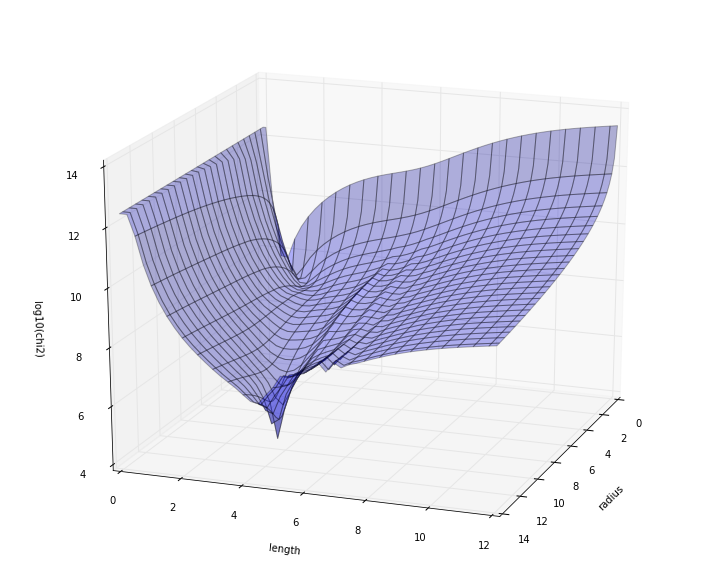

In [2]:
plot_chi2()